In [5]:
import numpy as np
import qiskit
import pennylane as qml
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector

from pennylane_snowflurry.test_device import TestDevice

# Parameters
M = 64  # Lattices
w1 = 0.5
w2 = 0.5
e1 = 1
e2 = -1
cs = 1
u = 0.2

x = w1 * (1 + e1 * u / cs**2)
y = w2 * (1 + e2 * u / cs**2)

lambda1 = np.arccos(x)
lambda2 = np.arccos(y)

def oneStep(lambda1, lambda2):
    # Initializing
    n = int(np.log2(2 * M))
    q = qiskit.QuantumRegister(n, 'q')
    a = qiskit.AncillaRegister(1, 'a')
    
    qc = qiskit.QuantumCircuit(q)
    qc.add_register(a)
    qc.barrier()

    # Collisions
    def createC(lambda1, lambda2, isC1=True):
        if not isC1:
            lambda1 *= -1
            lambda2 *= -1

        qc_temp = qiskit.QuantumCircuit(2)
        qc_temp.cp(lambda1, 0, 1, ctrl_state=0)
        qc_temp.cx(0, 1, ctrl_state=0)
        qc_temp.cp(lambda1, 0, 1, ctrl_state=0)
        qc_temp.cx(0, 1, ctrl_state=0)

        qc_temp.cp(lambda2, 0, 1, ctrl_state=1)
        qc_temp.cx(0, 1)
        qc_temp.cp(lambda2, 0, 1, ctrl_state=1)
        qc_temp.cx(0, 1)
        return qc_temp
    
    C1 = createC(lambda1, lambda2, True)
    c1gate = C1.to_gate(label='c1')
    C2 = createC(lambda1, lambda2, False)
    c2gate = C2.to_gate(label='c2')
    
    # Adding steps to circuit
    qc.h(a)
    qc.append(c1gate.control(1, ctrl_state=0), [a, n - 1, 0])
    qc.append(c2gate.control(1, ctrl_state=1), [a, n - 1, 0])
    qc.h(a)
    
    # Propagation
    def rshift(n):
        circ = qiskit.QuantumCircuit(n - 1)
        for i in range(n - 1):
            if i == n - 2:
                circ.x(i)
            else:
                circ.mcx(list(range(i + 1, n - 1)), i)
        return circ

    def lshift(n):
        circ = qiskit.QuantumCircuit(n - 1)
        for i in reversed(range(n - 1)):
            if i == n - 2:
                circ.x(i)
            else:
                circ.mcx(list(range(i + 1, n - 1)), i)
        return circ
    
    qc.barrier()
    R = rshift(n).to_gate(label="R").control(1, ctrl_state=0)
    L = lshift(n).to_gate(label="L").control(1, ctrl_state=1)
    
    cbits = [n - 1] + [i for i in range(n - 2, -1, -1)]
    qc.append(R, cbits)
    qc.append(L, cbits)

    # Macros
    qc.swap(a, n - 1)
    qc.h(a)
    
    return qc

# Create the Qiskit circuit
qc = oneStep(np.arccos(x), np.arccos(y))

# Convert Qiskit circuit to PennyLane circuit
my_circuit = qml.from_qiskit(qc)

# PennyLane device
dev = TestDevice(shots=1000)

@qml.qnode(dev)
def circuit(x):
    qml.RX(x, wires=1)  # Example input for the circuit
    my_circuit(wires=range(qc.num_qubits))
    return qml.counts(wires=0)

circuit(np.pi)
specs = qml.specs(circuit)()
print(specs)


# Initial State
initState = np.ones(M) / 10
initState[12] = 0.2
nrm = np.linalg.norm(initState)
initState = np.concatenate((initState, initState))

# Statevector
SV = Statevector(initState / np.linalg.norm(initState)).expand([1, 0])
initSV = SV

def timestep(sv):
    return sv.evolve(qc)

def graph(sv, color="red"):
    plt.plot(list(range(0, M, 1)), np.array(sv)[:M:1], color)
    plt.plot(list(range(M, 2 * M, 1)), np.array(sv)[M:2 * M:1], color)
    plt.plot(list(range(2 * M, 3 * M, 1)), np.array(sv)[2 * M:3 * M:1], color)
    plt.plot(list(range(3 * M, 4 * M, 1)), np.array(sv)[3 * M::1], color)

def hres(sv):
    plt.plot(list(range(0, M, 1)), 2 ** (1) * nrm * np.array(sv)[:M:])
    plt.xlabel("Lattice site")
    plt.ylabel("Concentration")

def reinit(sv):
    tmp = np.array(sv)[:M]
    tmp = np.concatenate((tmp, tmp))
    return Statevector(tmp / np.linalg.norm(tmp)).expand([1, 0])


c:\Users\bouch\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane_qiskit\converter.py:584: UserWarning: pennylane_qiskit.converter: The ControlledGate instruction is not supported by PennyLane, and has not been added to the template.
  warnings.warn(


TypeError: circuit() missing 1 required positional argument: 'x'

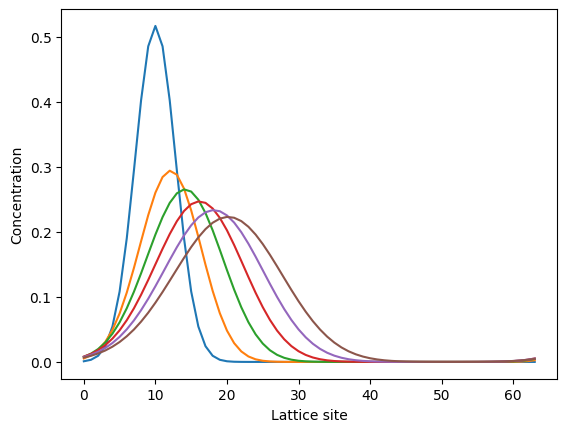

In [3]:
# Initial State for second part
x0 = 10
sig = 4 / np.sqrt(2)
tmar = [-(pos - x0) ** 2 / (2 * sig ** 2) for pos in range(64)]
tmar = np.exp(tmar)
nrm2 = np.linalg.norm(tmar)
tmar = np.concatenate((tmar, tmar))

# Statevector
SV2 = Statevector(tmar / np.linalg.norm(tmar)).expand([1, 0])
initSV2 = SV2 

hres(initSV2)
for i in range(1, 51):
    SV2 = timestep(SV2)
    if i % 10 == 0:
        hres(SV2)
    SV2 = reinit(SV2)

plt.show()
